# Declustering Variogram Workflow

This notebook demonstrates how to improve **variograms**  by **declustering** using *Ordinary Global Kriging (OGK)* and fourth-order covariances. The goal is to reduce the effect of preferential sampling and obtain a more stable and unbiased variogram.

This variogram declustering workflow is based on the methodology proposed in:

> Rezvandehy, M. & Deutsch, C.V. (2018). *Declustering experimental variograms by global estimation with fourth order moments.* Stochastic Environmental Research and Risk Assessment, 32, 261–277. https://DOI:10.1007/s00477-017-1388-x

Implemented in Python by:
Youngkeun Jung (yk.jung@utexas.edu), 09/24/2025

### 0. Import necessary libraries and functions
- Make sure variogram_declustering.py is in the same directory as this notebook. This module contains functions for variogram pair generation, OGK weight calculation, and declustered variogram computation.
- numpy, pandas, matplotlib for data handling and visualization.

In [6]:
from variogram_declustering import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

##### Make Sample Clustered Data

In [2]:
# 1. Generate clustered sample data
np.random.seed(42)
cluster1 = np.random.rand(80, 2) * 0.3 + np.array([0.1, 0.1])
vals1 = np.random.randn(80) * 0.5 + 5
cluster2 = np.random.rand(80, 2) * 0.3 + np.array([0.6, 0.6])
vals2 = np.random.randn(80) * 0.5 + 5
sparse = np.random.rand(40, 2)
vals_sparse = np.random.randn(40) * 0.5 + 5
all_coords = np.vstack([cluster1, cluster2, sparse])
all_values = np.concatenate([vals1, vals2, vals_sparse])
sample_df = pd.DataFrame({'x': all_coords[:, 0], 'y': all_coords[:, 1], 'value': all_values})

Visualize Data

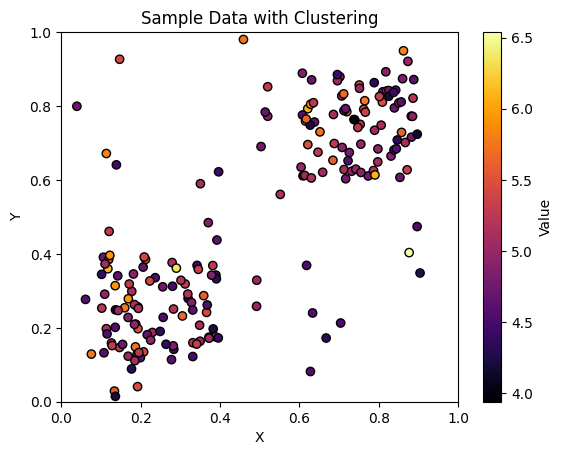

In [10]:
plt.scatter(sample_df['x'], sample_df['y'], c=sample_df['value'], cmap='inferno', edgecolor='black')
plt.colorbar(label='Value')
plt.title('Sample Data with Clustering')
plt.xlabel('X'); plt.ylabel('Y')
plt.xlim(0,1); plt.ylim(0,1)
plt.show()

### 1. Experimental Variogram

The starting point for this workflow is the **experimental variogram**, which quantifies spatial continuity:

$$
\hat{\gamma}(h) = \frac{1}{2n(h)} \sum_{i=1}^{n(h)} \big[ y(u_i) - y(u_i + h) \big]^2
$$

- $h$: lag distance  
- $n(h)$: number of data pairs separated by $h$  
- $y(u_i)$: sample value at location $u_i$  

For a more detailed introduction to variograms, their properties, and practical examples, see [Professor Pyrcz’s GeostatsPy e-book chapter](https://geostatsguy.github.io/GeostatsPyDemos_Book/GeostatsPy_variogram_calculation.html).  

This formulation assigns **equal weight** to all pairs.  
As a result, if sampling is **preferential or clustered** (e.g., more data in high-value areas), the experimental variogram can become:

- **noisy** (large fluctuations at short and long lags),  
- **biased** (over-representing certain regions), and  
- less reliable as a description of the true spatial structure.  



##### Calculate experimental variogram

In [27]:
lag_dist = 0.4
lag_tol = 0.1
azimuth = 0
azimuth_tol = 5
grid_res = 30 # Resolution for grid discretization method

initial_sill = np.var(sample_df['value'])
initial_range = 0.2
print(f"Assumed initial model: Sill={initial_sill:.2f}, Range={initial_range:.2f}")

print(f"\nFinding pairs for Lag={lag_dist} (±{lag_tol}), Azimuth={azimuth} (±{azimuth_tol})...")
found_pairs = generate_variogram_pairs(
    df=sample_df, xcol='x', ycol='y', vcol='value',
    lag=lag_dist, tol=lag_tol, azm=azimuth, atol=azimuth_tol
)

if not found_pairs:
    print("No data pairs found for the given conditions.")
else:
    print(f"Found {len(found_pairs)} pairs.")

Assumed initial model: Sill=0.23, Range=0.20

Finding pairs for Lag=0.4 (±0.1), Azimuth=0 (±5)...
Found 129 pairs.


Visualize found pairs

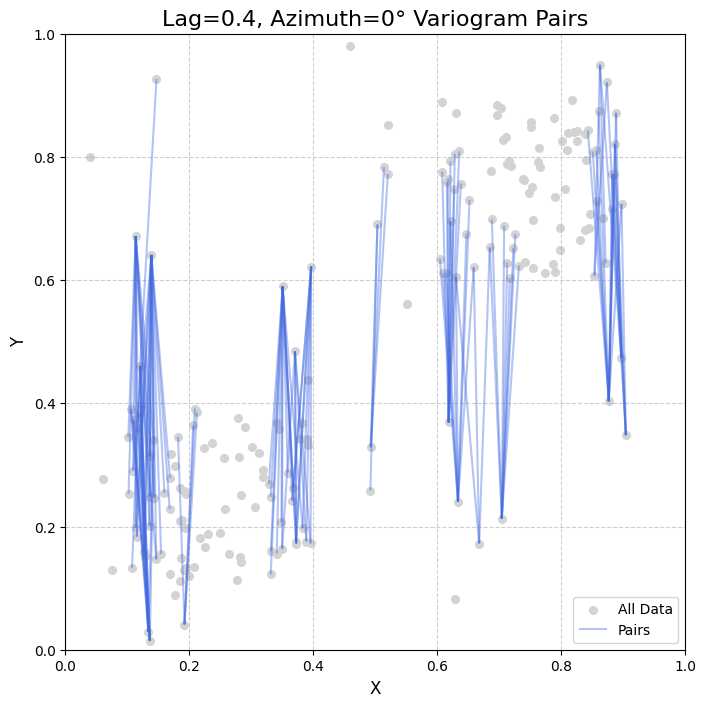

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(sample_df['x'], sample_df['y'], c='lightgray', s=30, label='All Data', zorder=1)

if found_pairs:
    lines = [[pair[0][0], pair[1][0]] for pair in found_pairs]
    lc = LineCollection(lines, colors='royalblue', linewidths=1.5, label='Pairs', zorder=2, alpha=0.4)
    ax.add_collection(lc)

ax.set_title(f'Lag={lag_dist}, Azimuth={azimuth}° Variogram Pairs', fontsize=16)
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlim(0,1); ax.set_ylim(0,1)
plt.show()

### 2. Weighted Variogram (Declustering)

To correct for preferential sampling, we introduce **weights** $w_i$ for variogram pairs:

$$
\hat{\gamma}_w(h) = \frac{1}{2} \sum_{i=1}^{n(h)} w_i \, \left[ y(u_i) - y(u_i + h) \right]^2,
\quad \sum_{i=1}^{n(h)} w_i = 1, \; w_i \geq 0
$$

The challenge is to compute appropriate weights $w_i$ that reduce clustering effects.

In this declustering approach, **each variogram pair is treated as a “datum”**.  
- The pair value is defined as half of the squared difference between tail and head samples.  
- By applying **Ordinary Global Kriging (OGK)** to these pair values, we obtain the **declustering weights** that properly account for preferential sampling.  

Rather than kriging raw sample values, we krige **pair values**, ensuring that clustering is corrected directly at the variogram level.

### 3. Global Kriging of Variogram Pairs

Each variogram pair is represented as:

$$
X_h(u) = \frac{1}{2}\left( Z(u - h/2) - Z(u + h/2) \right)^2
$$

The declustered variogram is obtained through global kriging of these pair values:

$$
\hat{\gamma}_{declustered}(h) = \sum_{a=1}^{n(h)} k_{a,h} \, X_a
$$

where $k_{a,h}$ are kriging-based declustering weights, computed by solving:

$$
\sum_{b=1}^{n(h)} k_{b,h} F(X_b, X_a) + \lambda = F(X_a, A),
\quad \sum_{a=1}^{n(h)} k_{a,h} = 1
$$

- $F(X_b, X_a)$: **fourth-order covariance** between pairs  
- $F(X_a, A)$: average covariance between a pair and the entire domain  


### 4. Fourth-order Covariance

The covariance between two variogram pairs can be written as:

$$
\text{Cov}\Big[(y_1 - y_2)^2 , (y_3 - y_4)^2 \Big] =
E\Big[(y_1 - y_2)^2 (y_3 - y_4)^2\Big] -
E[(y_1 - y_2)^2] \, E[(y_3 - y_4)^2]
$$

- $y_1, y_2$: tail and head of **Pair p**  
- $y_3, y_4$: tail and head of **Pair q**  


#### Expansion under Multivariate Gaussian Assumption

Rezvandehy & Deutsch (2018) show that under the **multivariate Gaussian assumption**,  
the fourth-order covariance can be expressed entirely in terms of **second-order covariances** (i.e., variogram values).  

Expanding the expectation:

$$
\begin{aligned}
\text{Cov}\Big[(y_1 - y_2)^2 , (y_3 - y_4)^2 \Big]
&= E[y_1^2 y_3^2] + E[y_1^2 y_4^2] - 2E[y_1^2 y_3 y_4] \\
&\quad + E[y_2^2 y_3^2] + E[y_2^2 y_4^2] - 2E[y_2^2 y_3 y_4] \\
&\quad - 2E[y_1 y_2 y_3^2] - 2E[y_1 y_2 y_4^2] + 4E[y_1 y_2 y_3 y_4] \\
&\quad - \; 2\gamma(h_p)\, \cdot \, 2\gamma(h_q)
\end{aligned}
$$

Here, $\gamma(h_p)$ and $\gamma(h_q)$ are the variogram values at lag distances of pair $p$ and pair $q$.  


#### Reduction to Second-order Moments

For a multivariate Gaussian random field, any **fourth-order moment** can be decomposed into a combination of **second-order covariances** (Matheron, 1965):

$$
E[y_1 y_2 y_3 y_4] =
\text{Cov}(y_1, y_2)\,\text{Cov}(y_3, y_4) +
\text{Cov}(y_1, y_3)\,\text{Cov}(y_2, y_4) +
\text{Cov}(y_1, y_4)\,\text{Cov}(y_2, y_3)
$$

Thus, the fourth-order covariance can be computed directly from the fitted variogram model, without requiring higher-order statistics.  

This step is what makes the declustering procedure feasible: we assume multivariate Gaussianity so that **weights for variogram pairs** can be calculated using only the fitted variogram (second-order model).


### Calculate declustered variogram value using OGK weights

In [32]:
# 5. Calculate weights using the new grid-based OGK method
ogk_weights = solve_ogk_weights(
    found_pairs, initial_sill, initial_range,
    data_coords=sample_df[['x', 'y']].values,
    grid_resolution=grid_res
)

# 6. Calculate the declustered variogram value
declustered_gamma = calculate_declustered_variogram_value(found_pairs, ogk_weights)
print(f"\nDeclustered variogram value: {declustered_gamma:.4f}")

# 7. (For comparison) Calculate traditional variogram value
traditional_gamma = 0.5 * np.mean([(p[0][1] - p[1][1])**2 for p in found_pairs])
print(f"Traditional variogram value (equal weights): {traditional_gamma:.4f}")

# Check the distribution of weights
print(f"\nCalculated Weights Summary:")
print(f"  - Min weight: {np.min(ogk_weights):.6f}")
print(f"  - Max weight: {np.max(ogk_weights):.6f}")
print(f"  - Sum of weights: {np.sum(ogk_weights):.4f}")  # Should be 1.0

Constructing OGK system for 129 pairs...
Calculating 'd' vector using a 30x30 discretized grid...
OGK system solved successfully.

Declustered variogram value: 0.3008
Traditional variogram value (equal weights): 0.3760

Calculated Weights Summary:
  - Min weight: -0.033717
  - Max weight: 0.043354
  - Sum of weights: 1.0000


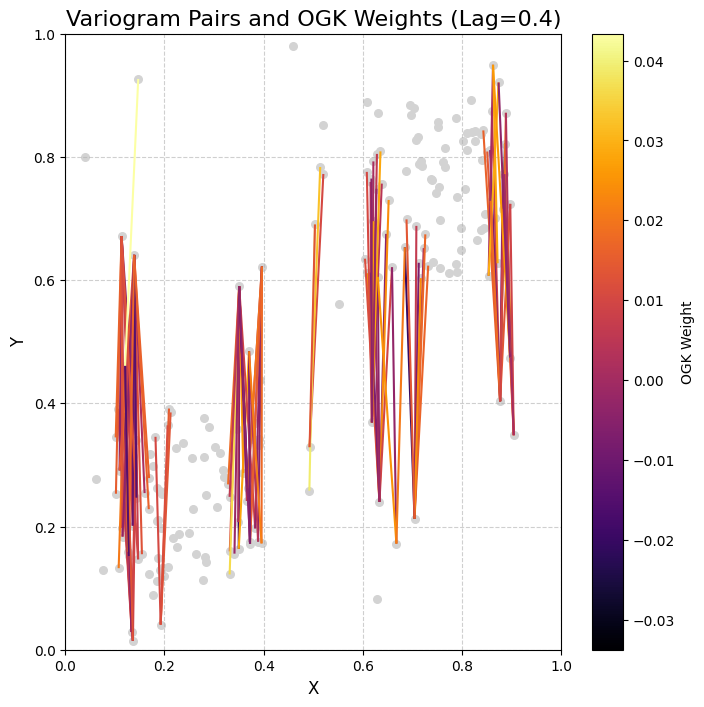

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot all data points as a background
ax.scatter(sample_df['x'], sample_df['y'], c='lightgray', s=30, label='All Data Points', zorder=1)

# Create a list of line segments for the found pairs
lines = [[pair[0][0], pair[1][0]] for pair in found_pairs]

# Create a LineCollection, mapping weights to a colormap
lc = LineCollection(lines, cmap='inferno', linewidths=1.5, zorder=2)
lc.set_array(ogk_weights)
ax.add_collection(lc)

# Add a color bar to show the weight scale
fig.colorbar(lc, ax=ax, label='OGK Weight')

ax.set_title(f'Variogram Pairs and OGK Weights (Lag={lag_dist})', fontsize=16)
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlim(0,1); ax.set_ylim(0,1)
plt.show()

### Build the full variogram by repeating for all lags

By repeating the above workflow for each lag, we obtain the declustered variogram.

Warning: This step can be computationally intensive depending on the number of lags and data size. Simplifications are made here for demonstration purposes.

In [50]:
max_dist = np.sqrt(np.max(all_coords[:,0])**2 + np.max(all_coords[:,1])**2)
lags = np.linspace(0.1, max_dist / 2, 10)
lag_tol = lags[0]/2# Use a tolerance relative to the lag step

traditional_gammas = []
declustered_gammas = []
pair_counts = []

print("Building full variogram for all lags...")
# 4. Loop through each lag to calculate variogram points
for lag in lags:
    print(f"  Calculating for lag = {lag:.2f}...")

    # Find pairs for the current lag
    found_pairs = generate_variogram_pairs(
        df=sample_df, xcol='x', ycol='y', vcol='value',
        lag=lag, tol=lag_tol, azm=azimuth, atol=azimuth_tol
    )
    pair_counts.append(len(found_pairs))

    if not found_pairs:
        traditional_gammas.append(np.nan)
        declustered_gammas.append(np.nan)
        continue

    # Calculate traditional variogram value (equal weights)
    squared_diffs = np.array([(p[0][1] - p[1][1])**2 for p in found_pairs])
    traditional_gamma = 0.5 * np.mean(squared_diffs)
    traditional_gammas.append(traditional_gamma)

    # Calculate OGK weights
    ogk_weights = solve_ogk_weights(
        found_pairs, initial_sill, initial_range,
        data_coords=sample_df[['x', 'y']].values,
        grid_resolution=grid_res
    )

    # Calculate declustered variogram value
    declustered_gamma = calculate_declustered_variogram_value(found_pairs, ogk_weights)
    declustered_gammas.append(declustered_gamma)

print("Calculation complete.")

Building full variogram for all lags...
  Calculating for lag = 0.10...
Constructing OGK system for 185 pairs...
Calculating 'd' vector using a 30x30 discretized grid...
OGK system solved successfully.
  Calculating for lag = 0.16...
Constructing OGK system for 240 pairs...
Calculating 'd' vector using a 30x30 discretized grid...
OGK system solved successfully.
  Calculating for lag = 0.23...
Constructing OGK system for 190 pairs...
Calculating 'd' vector using a 30x30 discretized grid...
OGK system solved successfully.
  Calculating for lag = 0.29...
Constructing OGK system for 107 pairs...
Calculating 'd' vector using a 30x30 discretized grid...
OGK system solved successfully.
  Calculating for lag = 0.35...
Constructing OGK system for 69 pairs...
Calculating 'd' vector using a 30x30 discretized grid...
OGK system solved successfully.
  Calculating for lag = 0.41...
Constructing OGK system for 68 pairs...
Calculating 'd' vector using a 30x30 discretized grid...
OGK system solved succ

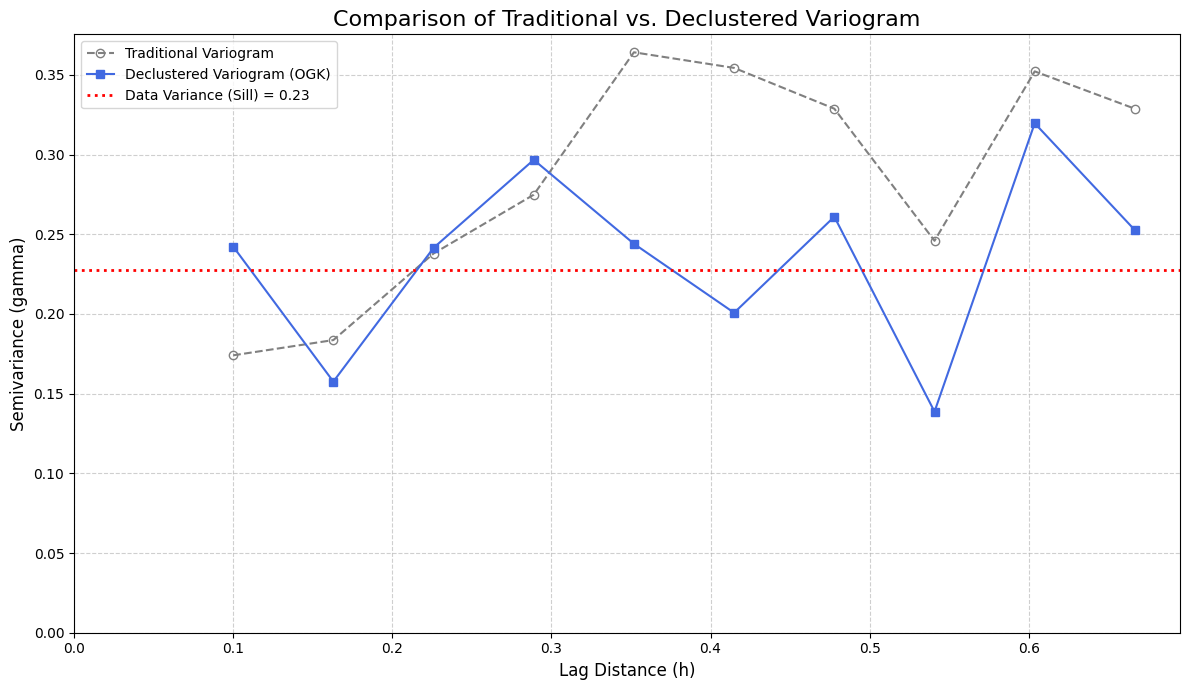

In [51]:
plt.figure(figsize=(12, 7))
plt.plot(lags, traditional_gammas, 'o--', color='gray', label='Traditional Variogram', mfc='none')
plt.plot(lags, declustered_gammas, 's-', color='royalblue', label='Declustered Variogram (OGK)')

plt.axhline(y=initial_sill, color='red', linestyle=':', linewidth=2, label=f'Data Variance (Sill) = {initial_sill:.2f}')

plt.title('Comparison of Traditional vs. Declustered Variogram', fontsize=16)
plt.xlabel('Lag Distance (h)', fontsize=12)
plt.ylabel('Semivariance (gamma)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()